# Install Requirements

In [43]:
# !git clone https://www.github.com/camelot-dev/camelot

# NOTE: camelot has some issues while working with the table detection. It fails sometimes if bounding box area appears to be 0. (It's a bug)
# In order to overcome that issue I tried to modify the code in `camelot/utils.py` module on line 376 that modified one looks like:
# `if bbox_area(ba) == 0 or (bbox_intersection_area(ba, bb) / bbox_area(ba)) > 0.8:`
# Then build the code from repository and it works. RUN: !cd camelot && pip install ".[cv]"
# PLEASE CHECK file `~/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/camelot/utils.py` to make sure modification is done in library.

In [28]:
# !pip install layoutparser
# !pip install "camelot-py[cv]" # This is the regular way of installing camelot but prefer the way presented above for installation
# !sudo yum upgrade
# !sudo yum update
# !sudo yum install python3-tkinter -y
# !sudo yum install ghostscript

# Imports

In [1]:
from camelot.utils import text_in_bbox

In [2]:
import camelot
import io
import layoutparser as lp
import pandas as pd
import json
import tqdm
from PIL import Image
from PIL import ImageDraw
import PIL
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# SOP Table Extraction Example

In [3]:
SOP = "MCD-088122"
SOP = "LAB-2352"

SOP_TYPE = "Andover"

PAGE_ID = 5

## Extract Tables

In [4]:
def extract_tables(filename):
    tables_per_page = {}
    for page_id in tqdm.tqdm(range(1, 1000), desc=f"reading {filename} pages"):
        try:
            tables = camelot.read_pdf(filename, pages=str(page_id))
            tables_per_page[page_id - 1] = [table for table in tables] 
        except:
            break
            
    return tables_per_page

In [5]:
def get_table_dfs(tables):
    table_dfs = {}
    for page_id, page_tables in tables.items():
        table_dfs[page_id] = []

        for table in page_tables:
            table_dfs[page_id].append(table.df)
            
    return table_dfs

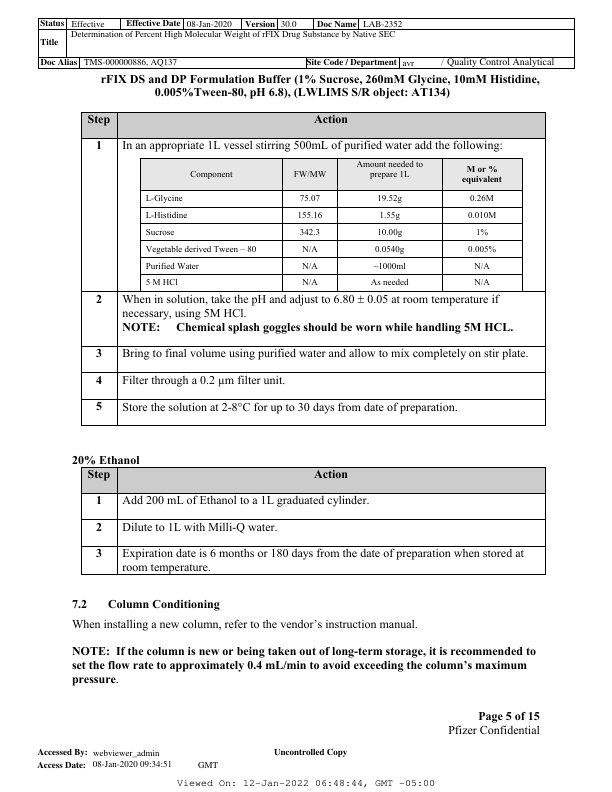

In [6]:
_img = lp.load_pdf(f'data/sop/{SOP_TYPE}/{SOP}.pdf', load_images=True)[1][PAGE_ID]
_img

In [ ]:
_tables = extract_tables(filename=f'data/sop/{SOP_TYPE}/{SOP}.pdf')

reading data/sop/Andover/LAB-2352.pdf pages:   0%|          | 4/999 [00:16<1:06:50,  4.03s/it]

In [8]:
_table_dfs = get_table_dfs(_tables)

In [9]:
len(_table_dfs[PAGE_ID])
_table_dfs[PAGE_ID][0]
_table_dfs[PAGE_ID][1]
# _table_dfs[PAGE_ID][2]

2

,0,1,2,3,4,5,6
0,Step,Action,,,,,
1,1,In an appropriate 1L vessel stirring 500mL of ...,,,,,
2,,,Component,FW/MW,Amount needed to \nprepare 1L,M or % \nequivalent,
3,,,L-Glycine,75.07,19.52g,0.26M,
4,,,L-Histidine,155.16,1.55g,0.010M,
5,,,Sucrose,342.3,10.00g,1%,
6,,,Vegetable derived Tween – 80,N/A,0.0540g,0.005%,
7,,,Purified Water,N/A,~1000ml,N/A,
8,,,5 M HCl,N/A,As needed,N/A,
9,2,"When in solution, take the pH and adjust to 6....",,,,,


,0,1
0,Step,Action
1,1,Add 200 mL of Ethanol to a 1L graduated cylinder.
2,2,Dilute to 1L with Milli-Q water.
3,3,Expiration date is 6 months or 180 days from t...


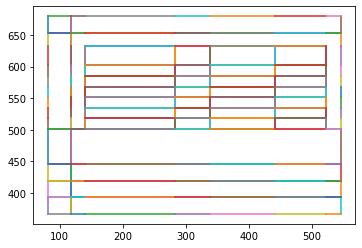

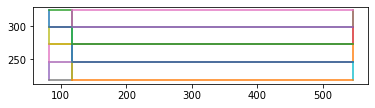

In [10]:
camelot.plot(_tables[PAGE_ID][0], kind='grid').show()
camelot.plot(_tables[PAGE_ID][1], kind='grid').show()
# camelot.plot(_tables[PAGE_ID][2], kind='grid').show()

# Draw Cell Boundaries

In [6]:
FILL_COLORS = ['red', 'blue', 'green', 'yellow', 'brown', 'chocolate', 'cyan']

In [7]:
def draw_table_grid(table, image, fill=None, width=2):
    img_copy = image.copy()
    drawer = ImageDraw.Draw(img_copy)
    
    if not fill:
        fill = random.choice(FILL_COLORS)
    
    height = image.size[1]
    for row in table.cells:
        for cell in row:
            if cell.left:
                drawer.line([(cell.lb[0], height - cell.lb[1]), (cell.lt[0], height - cell.lt[1])], fill=fill, width=width)
            if cell.right:                                       
                drawer.line([(cell.rb[0], height - cell.rb[1]), (cell.rt[0], height - cell.rt[1])], fill=fill, width=width)
            if cell.top:                                         
                drawer.line([(cell.lt[0], height - cell.lt[1]), (cell.rt[0], height - cell.rt[1])], fill=fill, width=width)
            if cell.bottom:                                      
                drawer.line([(cell.lb[0], height - cell.lb[1]), (cell.rb[0], height - cell.rb[1])], fill=fill, width=width)
    return img_copy

In [8]:
def draw_multiple_table_grid(tables, image, fill=None, width=2):
    img_copy = image.copy()
    drawer = ImageDraw.Draw(img_copy)
    
    if fill:
        fills = [fill for _ in range(len(tables))]
    else:
        fills = random.sample(FILL_COLORS, len(tables))
        
    for table, fill_color in zip(tables, fills):
        height = image.size[1]
        for row in table.cells:
            for cell in row:
                if cell.left:
                    drawer.line([(cell.lb[0], height - cell.lb[1]), (cell.lt[0], height - cell.lt[1])], fill=fill_color, width=width)
                if cell.right:                                       
                    drawer.line([(cell.rb[0], height - cell.rb[1]), (cell.rt[0], height - cell.rt[1])], fill=fill_color, width=width)
                if cell.top:                                         
                    drawer.line([(cell.lt[0], height - cell.lt[1]), (cell.rt[0], height - cell.rt[1])], fill=fill_color, width=width)
                if cell.bottom:                                      
                    drawer.line([(cell.lb[0], height - cell.lb[1]), (cell.rb[0], height - cell.rb[1])], fill=fill_color, width=width)
        
        
    return img_copy

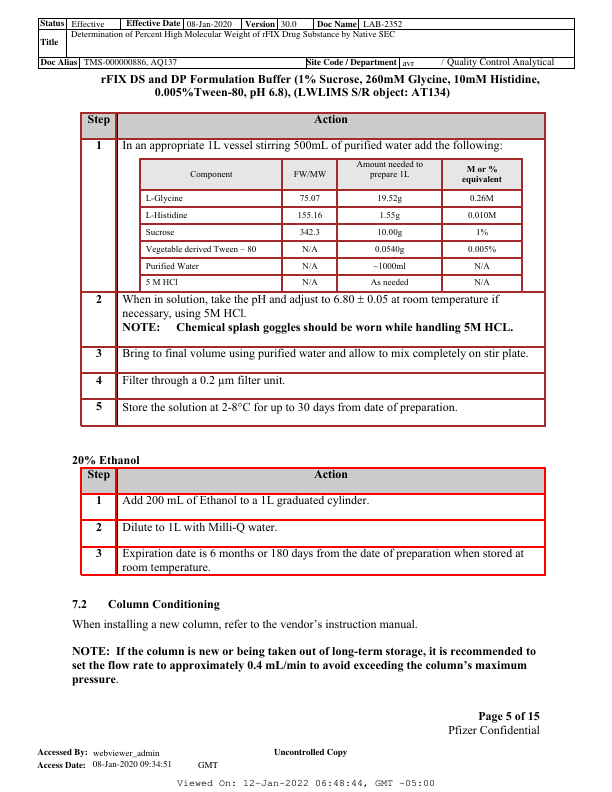

In [14]:
draw_multiple_table_grid(_tables[PAGE_ID][0:2], _img)

# Detect Tables on All SOPs

In [15]:
# make directory for storing table detections
# !mkdir --parent data/sop_tables_camelot/ data/sop_tables_camelot/GC data/sop_tables_camelot/Andover data/sop_tables_camelot/Kalamazoo data/sop_tables_camelot/McPherson

In [9]:
import os
import tqdm

In [10]:
SOP_DIR = "data/sop"

SOP_TABLES_DIR = "data/sop_tables_camelot"

SOP_TYPES = [
    "GC",
    "Andover",
    "Kalamazoo",
    "McPherson"
]

In [11]:
def detect_tables(filename):
    pdf_layout, pdf_images = lp.load_pdf(filename, load_images=True)
    
    pdf_images_with_table_boxes = []
    table_dfs_per_page = []
    for page_idx, image in enumerate(pdf_images):
        
        # detect tables using camelot
        page_tables = camelot.read_pdf(filename, pages=str(page_idx+1))
        
        # get bounding boxes on page as an image
        pdf_images_with_table_boxes.append(draw_multiple_table_grid(page_tables, image))
        
        # extract tables as pandas DataFrames
        table_dfs = []
        for table_idx, table in enumerate(page_tables):
            try:
                table_dfs.append(table.df)
            except:
                print(f"Error converting table to dataframe!\nFilename:{filename}\tPage:{page_idx}\tTable:{table_idx}\nData:{table}\n")
                
        table_dfs_per_page.append(table_dfs)

    return pdf_images_with_table_boxes, table_dfs_per_page

In [12]:
def images_to_pdf(images, filename):
    if images:
        images[0].save(filename, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:])

In [13]:
def tables_to_csv(tables, dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
        
    for page_idx, page_tables in enumerate(tables):
        for table_idx, table in enumerate(page_tables):
            table.to_csv(f"{dir}/table_{page_idx}_{table_idx}.csv")

In [14]:
# def to_json(data, filename):
#     with open(filename, 'w') as file:
#         json.dump(data, file)

In [16]:
sop_file_path = f"data/sop/{SOP_TYPE}/{SOP}.pdf"

In [23]:
%time detected_tables, table_dfs = detect_tables(sop_file_path)

100%|██████████| 16/16 [01:05<00:00,  4.09s/it]

CPU times: user 1min 8s, sys: 1.32 s, total: 1min 9s
Wall time: 1min 9s


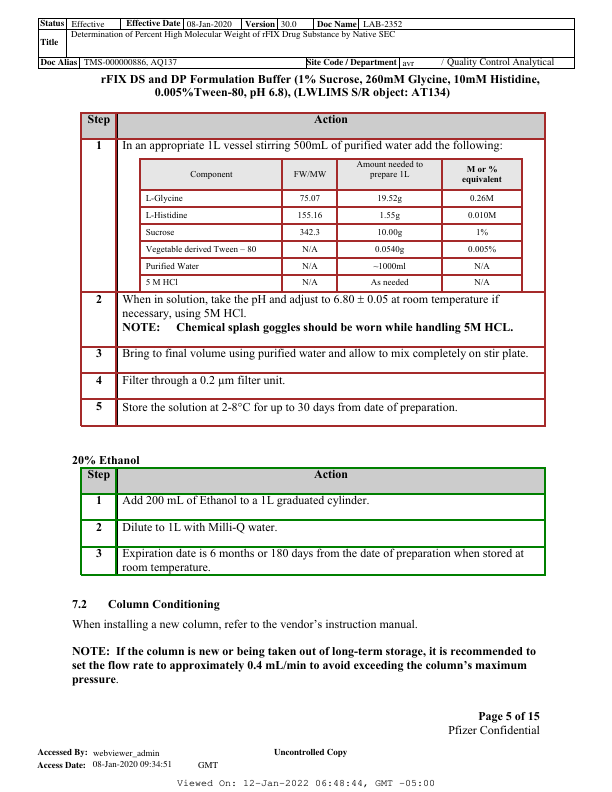

In [24]:
detected_tables[PAGE_ID]

In [ ]:
for sop_type in SOP_TYPES:
    _subdir = os.path.join(SOP_DIR, sop_type)
    
    for sop_filename in tqdm.tqdm(os.listdir(_subdir), desc=f"{sop_type} SOPs", leave=False):
        if sop_filename.endswith('.pdf'):
            _sop_file_id = sop_filename.rstrip('.pdf')
            
            _sop_file_path = os.path.join(SOP_DIR, sop_type, sop_filename)
            _sop_tables_file_path = os.path.join(SOP_TABLES_DIR, sop_type, sop_filename)
            _sop_tables_dir_path = os.path.join(SOP_TABLES_DIR, sop_type, _sop_file_id)
            
            detected_tables, tables_dfs = detect_tables(filename=_sop_file_path)
            images_to_pdf(images=detected_tables, filename=_sop_tables_file_path)
            tables_to_csv(tables=tables_dfs, dir=_sop_tables_dir_path)
            
        else:
            print(f"Skipping Invalid File:{os.path.join(_subdir, sop_filename)}!!")

GC SOPs:  25%|██▌       | 8/32 [10:50<34:21, 85.91s/it]   